In [1]:
# Thư viện sử dụng
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyvi import ViTokenizer
import re
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Định nghĩa lớp Attention
class Attention(tf.keras.layers.Layer):
    def __init__(self, return_sequences=False):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")

        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)

        if self.return_sequences:
            return a * x
        else:
            return K.sum(a * x, axis=1)

In [3]:
# Tạo DataFrame mới chỉ chứa 2 cột "Summary" và "Category"
data = pd.read_excel("data.xlsx") #thay thế bằng dữ liệu sau tiền xử lý
lstm_train_data = data.copy()
lstm_train_data = lstm_train_data[["tokenized_contents", "Category"]]
lstm_train_data.head(3)

,tokenized_contents,Category
0,quý iii giao_dịch bất_động_sản thị_trường đà_n...,Bất động sản
1,tin_tưởng hùn vốn giám_đốc công_ty bất_động_sả...,Bất động sản
2,chủ_tịch ubnd tỉnh bắc ninh phê_duyệt quy_hoạc...,Bất động sản


In [4]:
# Chia thành cột tokenized_contents và cột Category
sentences = lstm_train_data['tokenized_contents'].tolist()
labels = lstm_train_data['Category'].tolist()
lstm_train_data['Category'].unique()

array(['Bất động sản', 'Công nghệ', 'Văn hóa - Giải trí',
       'Gia đình - Hôn nhân', 'Giáo dục', 'Tấm Lòng Vàng', 'Pháp luật',
       'Sức khỏe', 'Thông tin tiện ích', 'Thế giới', 'Thể thao',
       'Tin tức việc làm', 'Xe +'], dtype=object)

In [5]:
# Sử dụng LabelEncoder để mã hóa nhãn
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded

array([ 0,  0,  0, ..., 12, 12, 12], dtype=int64)

In [6]:
# Xử lý dữ liệu văn bản
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
sequences = tokenizer.texts_to_sequences(sentences)
sequences[:1]

[[501,
  2623,
  94,
  47,
  75,
  2,
  51,
  34,
  5,
  364,
  398,
  1044,
  1716,
  14,
  78,
  14,
  123,
  793,
  211,
  953,
  706,
  588,
  266,
  208,
  34,
  5]]

In [7]:
# Chia thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(sequences, labels_encoded, test_size=0.2, random_state=42)

In [8]:
# Xử lý dữ liệu đầu vào
max_length = max(len(seq) for seq in sequences)
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)
X_train

array([[   0,    0,    0, ...,  201,    8,    4],
       [   0,    0,    0, ...,  996,  708,  340],
       [   0,    0,    0, ..., 1102,  481,    5],
       ...,
       [   0,    0,    0, ..., 6316, 6317, 6318],
       [   0,    0,    0, ...,  150,  928,   39],
       [   0,    0,    0, ...,  159, 2924, 3395]])

In [9]:
# Chuẩn bị nhãn & Mô hình
num_classes = len(label_encoder.classes_)
one_hot_labels_train = to_categorical(y_train, num_classes=num_classes)
one_hot_labels_test = to_categorical(y_test, num_classes=num_classes)

embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Attention())
# model.add(Dense(num_classes, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
usemodel = model.fit(X_train, one_hot_labels_train, batch_size=16, epochs=5, validation_data=(X_test, one_hot_labels_test), verbose=0)

In [11]:
epochs=5

# Hiển thị loss và accuracy của từng epoch
train_loss = usemodel.history['loss']
train_accuracy = usemodel.history['accuracy']
val_loss = usemodel.history['val_loss']
val_accuracy = usemodel.history['val_accuracy']

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss[epoch]:.4f} - Train Accuracy: {train_accuracy[epoch]:.4f}")
    print(f"  Val Loss: {val_loss[epoch]:.4f} - Val Accuracy: {val_accuracy[epoch]:.4f}")

Epoch 1/5
  Train Loss: 2.0124 - Train Accuracy: 0.2820
  Val Loss: 1.6193 - Val Accuracy: 0.4399
Epoch 2/5
  Train Loss: 1.1894 - Train Accuracy: 0.6036
  Val Loss: 1.0863 - Val Accuracy: 0.6496
Epoch 3/5
  Train Loss: 0.7394 - Train Accuracy: 0.7719
  Val Loss: 0.8458 - Val Accuracy: 0.7431
Epoch 4/5
  Train Loss: 0.4588 - Train Accuracy: 0.8642
  Val Loss: 0.8476 - Val Accuracy: 0.7461
Epoch 5/5
  Train Loss: 0.3280 - Train Accuracy: 0.9083
  Val Loss: 0.7872 - Val Accuracy: 0.7697


In [12]:
# Đánh giá mô hình trên tập kiểm tra
loss, accuracy = model.evaluate(X_test, one_hot_labels_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

63/63 [==============================] - 4s 61ms/step - loss: 0.7872 - accuracy: 0.7697
Loss: 0.7871654033660889
Accuracy: 0.7697335481643677


In [13]:
# Lưu mô hình với encoding UTF-8
joblib.dump(model, 'lstm_model.joblib')

['lstm_model.joblib']

In [14]:
#-------------------------------------------------------------------------------------------------------------------------------------------
# Sử dụng mô hình (Mẫu)

# Đường dẫn tới tệp stopword
stopword_file = 'vietnamese.txt'

# Đọc danh sách từ stopword từ tệp
with open(stopword_file, 'r', encoding='utf-8') as f:
    stopword_list = [word.strip() for word in f.readlines()]

# Chuẩn bị câu mới
new_sentences = [
    "Sự phát triển của ngành công nghiệp điện ảnh đã tạo ra nhiều phim ảnh sáng tạo và hấp dẫn, mang đến cho khán giả trải nghiệm giải trí độc đáo.",
    "Công nghệ AI đang thay đổi cách chúng ta tương tác với thế giới, từ việc giúp chúng ta tìm kiếm thông tin nhanh chóng đến việc tạo ra trợ lý ảo thông minh.",
    "Thay đổi khí hậu đang là một vấn đề toàn cầu cấp bách, yêu cầu sự hợp tác và hành động quyết liệt từ tất cả các quốc gia trên thế giới."
]

# Tiền xử lý câu mới
preprocessed_sentences = []
for sentence in new_sentences:
    sentence = re.sub(r'[^\w\s]', '', sentence)
    sentence = ViTokenizer.tokenize(sentence)
    words = sentence.split()
    words = [word for word in words if word.lower() not in stopword_list]
    sentence = ' '.join(words)
    preprocessed_sentences.append(sentence)

# Chuyển đổi câu mới thành chuỗi số
new_sequences = tokenizer.texts_to_sequences(preprocessed_sentences)
new_sequences = pad_sequences(new_sequences, maxlen=max_length)

# Dự đoán nhãn cho các câu mới
predictions = model.predict(new_sequences)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# In kết quả dự đoán
for sentence, label in zip(new_sentences, predicted_labels):
    print("Sentence:", sentence)
    print("Predicted label:", label)
    print()

predicted_labels

1/1 [==============================] - 1s 1s/step
Sentence: Sự phát triển của ngành công nghiệp điện ảnh đã tạo ra nhiều phim ảnh sáng tạo và hấp dẫn, mang đến cho khán giả trải nghiệm giải trí độc đáo.
Predicted label: Văn hóa - Giải trí

Sentence: Công nghệ AI đang thay đổi cách chúng ta tương tác với thế giới, từ việc giúp chúng ta tìm kiếm thông tin nhanh chóng đến việc tạo ra trợ lý ảo thông minh.
Predicted label: Công nghệ

Sentence: Thay đổi khí hậu đang là một vấn đề toàn cầu cấp bách, yêu cầu sự hợp tác và hành động quyết liệt từ tất cả các quốc gia trên thế giới.
Predicted label: Thể thao



array(['Văn hóa - Giải trí', 'Công nghệ', 'Thể thao'], dtype='<U19')

In [15]:
# Thư viện sử dụng
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Completed training 1 time(s). Training time: 52.88s
Completed training 2 time(s). Training time: 50.81s
Completed training 3 time(s). Training time: 48.79s
Completed training 4 time(s). Training time: 50.03s
Completed training 5 time(s). Training time: 47.93s
Completed training 6 time(s). Training time: 46.65s
Completed training 7 time(s). Training time: 50.21s
Completed training 8 time(s). Training time: 47.18s
Completed training 9 time(s). Training time: 47.01s
Completed training 10 time(s). Training time: 46.57s


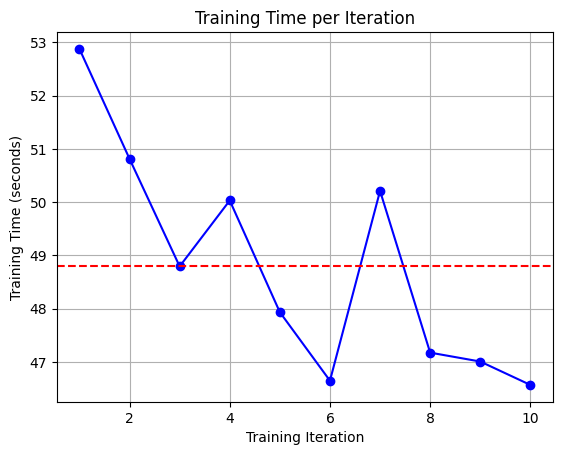

63/63 [==============================] - 3s 49ms/step
Accuracy: 0.78
Precision: 0.80
Recall: 0.76
F1-score: 0.77


In [16]:
#-------------------------------------------------------------------------------------------------------------------------------------------
# Đánh giá siêu tham số của mô hình

# Huấn luyện mô hình - Timing - 6 tiếng
batch_size = 32
epochs = 1

train_times = []  # Lưu trữ thời gian huấn luyện

for i in range(10):
    start_time = time.time()
    history = model.fit(X_train, one_hot_labels_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, one_hot_labels_test), verbose=0)
    end_time = time.time()
    train_time = end_time - start_time
    train_times.append(train_time)
    print(f"Completed training {i + 1} time(s). Training time: {train_time:.2f}s")

# Vẽ đồ thị thời gian huấn luyện
plt.plot(range(1, 11), train_times, marker='o', linestyle='-', color='blue')
plt.axhline(y=np.mean(train_times), color='red', linestyle='--')
plt.xlabel('Training Iteration')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time per Iteration')
plt.grid(True)
plt.show()

# Đánh giá mô hình trên tập kiểm tra
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(one_hot_labels_test, axis=1)

accuracy = np.mean(y_pred == y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

63/63 [==============================] - 3s 50ms/step


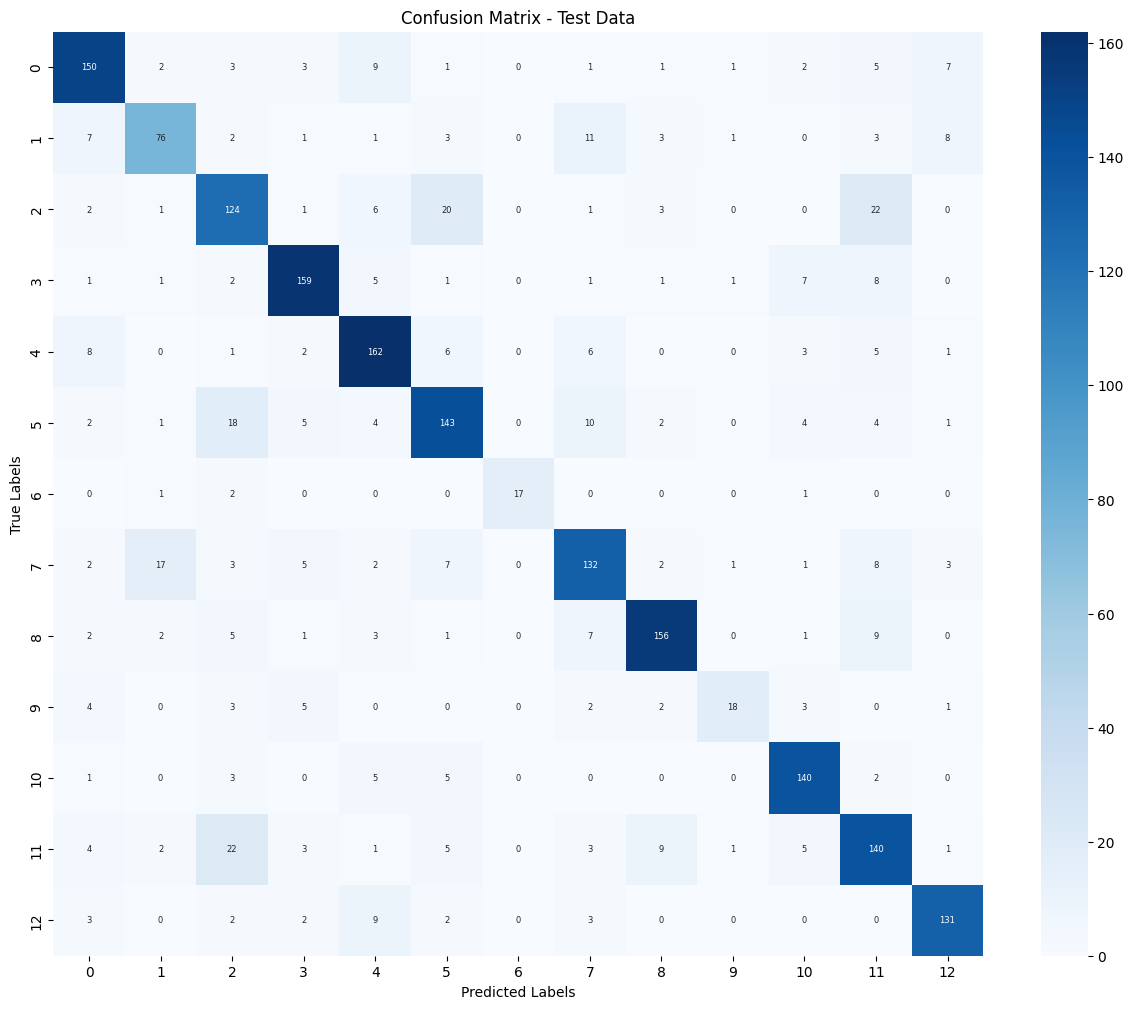

In [17]:
#-------------------------------------------------------------------------------------------------------------------------------------------
# Biểu diễn trực quan mô hình (Dự đoán - Thực tế)

# Dự đoán nhãn trên tập kiểm tra
test_predictions = model.predict(X_test)
test_predicted_labels = label_encoder.inverse_transform(np.argmax(test_predictions, axis=1))

# Tính toán ma trận nhầm lẫn trên tập kiểm tra
test_cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(one_hot_labels_test, axis=1)), test_predicted_labels)

# Trực quan hóa ma trận nhầm lẫn trên tập kiểm tra
plt.figure(figsize=(15, 12))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 6})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Data')
plt.show()